### Multi Agent Suprvisor With RAG
Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

In this tutorial, you will build a supervisor system with two agents — a research and a math expert. By the end of the tutorial you will:

1. Build specialized research and math agents
2. Build a supervisor for orchestrating them with the prebuilt langgraph-supervisor
3. Build a supervisor 
4. Implement advanced task delegation


In [11]:
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langgraph.prebuilt import create_react_agent
import os

In [4]:
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))

In [5]:
tavily_tool=TavilySearchResults(max_results=4)

C:\Users\user\AppData\Local\Temp\ipykernel_22520\3013242150.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_tool=TavilySearchResults(max_results=4)


In [6]:
urls = ["https://parspack.com/blog/online-business/what-is-blog",
        "https://parspack.com/blog/online-business/seo-tutorial/what-is-keyword-mapping"]
docs = []
for url in urls:
    loader = WebBaseLoader(url)
    docs.extend(loader.load())

In [7]:
# normalizer
import re

def normalize_persian(text: str) -> str:
    text = text.replace("ي", "ی").replace("ك", "ک")
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [8]:
# function to create a retrieval tool
from langchain_core.tools import tool , StructuredTool
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=80,separators=["\n\n", "\n", ".", " "])
texts = text_splitter.split_documents(docs)
for doc in texts:
    doc.page_content = normalize_persian(doc.page_content)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
vectorstore = FAISS.from_documents(texts, embedding_model)
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k":3})
def make_retriever_tool_from_text(name, desc):

    
    def tool_func(query: str) -> str:
        print(f"Using tool: {name}")
        query = normalize_persian(query)
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)

    return StructuredTool.from_function(
        func=tool_func,
        name=name,
        description=desc)


internal_tool_1=make_retriever_tool_from_text(
                                              name ="InternalResearchNotes",
                                              desc ="Search internal research notes for experimental results")

C:\Users\user\AppData\Local\Temp\ipykernel_22520\4188334017.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent=create_react_agent(


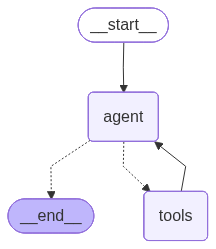

In [12]:
# Research Agent
research_agent=create_react_agent(
    model=llm,
    tools=[tavily_tool,internal_tool_1],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent"
)
research_agent

In [13]:
# Math Agent
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent=create_react_agent(
    model=llm,
    tools=[add,multiply,divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent"

)

C:\Users\user\AppData\Local\Temp\ipykernel_22520\2541061862.py:17: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  math_agent=create_react_agent(


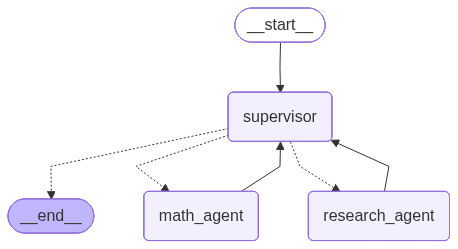

In [17]:
# Supervisor Agent
from langgraph_supervisor import create_supervisor
supervisor=create_supervisor(
    model=llm,
    agents=[research_agent,math_agent],
    prompt=(
         "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."

    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

supervisor

In [18]:
response=supervisor.invoke({"messages":"یک متن یک پاراگراف درباره بلاگ تولید کن و در اخر بگو 4 ضرب در 3 چند میشه "})

In [23]:
response["messages"]

[HumanMessage(content='یک متن یک پاراگراف درباره بلاگ تولید کن و در اخر بگو 4 ضرب در 3 چند میشه ', additional_kwargs={}, response_metadata={}, id='4ea901e3-6112-48c5-9afd-b6581ecf104a'),
 AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks in Persian: "یک متن یک پاراگراف درباره بلاگ تولید کن و در اخر بگو 4 ضرب در 3 چند میشه" => "Generate a one-paragraph text about a blog and at the end say what is 4 times 3."\n\nWe have to assign tasks to either research agent (for text) or math agent (for multiplication). The instruction: assign work to one agent at a time, not parallel. So we need to first assign to research agent to produce the paragraph about a blog. Then after receiving that, assign to math agent to compute 4*3 and maybe append. Or we could ask research agent to also include the math answer? But that is both research and math. Better to separate: first get paragraph from research, then get answer from math, then combine? But we cannot do work ourselves. We